In [ ]:
# ===============================================================
# FINAL PIPELINE (Option A) — 1000 videos, checkpoints every 10
# RetinaFace (InsightFace) + DeepFace (emotion) + Wav2Vec2 + Prosody + CLIP
# ===============================================================

# 0) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 1) Installs (run once per session)
# If you already installed some packages, these will be fast / no-op.
!pip -q install deepface==0.0.93 insightface==0.7.3 onnxruntime ftfy regex tqdm transformers==4.44.2
!pip -q install git+https://github.com/openai/CLIP.git
!pip -q install torchaudio librosa moviepy

# 2) Imports
import os, shutil, warnings, pickle, cv2, librosa, torch, numpy as np, pandas as pd, time
from tqdm import tqdm
from moviepy.editor import VideoFileClip
from PIL import Image
import torchaudio
warnings.filterwarnings("ignore")

# Models
import clip
from deepface import DeepFace
from insightface.app import FaceAnalysis
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# 3) Paths & settings (update if needed)
BASE_DIR = "/content/drive/MyDrive/NNdl/NNDL_Project"
FULL_ANNOT_CSV = os.path.join(BASE_DIR, "subset_annotations.csv")
FULL_VIDEO_DIR = os.path.join(BASE_DIR, "train_subset_3k")

OUT_DIR = os.path.join(BASE_DIR, "Seq_features_fast_1000_checkpointed")
VIDEO_DEST = os.path.join(OUT_DIR, "videos_1000")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(VIDEO_DEST, exist_ok=True)

# checkpoint files
CKPT_X = os.path.join(OUT_DIR, "seq_X_partial.pkl")
CKPT_Y = os.path.join(OUT_DIR, "seq_y_partial.pkl")
CKPT_ID = os.path.join(OUT_DIR, "seq_id_partial.pkl")

FINAL_X = os.path.join(OUT_DIR, "seq_X.npy")
FINAL_Y = os.path.join(OUT_DIR, "seq_y.npy")
FINAL_ID = os.path.join(OUT_DIR, "seq_id.npy")

# params
SAMPLE_SIZE = 1000
FRAME_SKIP = 12         # sample every Nth frame
CHECKPOINT_EVERY = 10   # save after every 10 videos
RANDOM_SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# 4) Load models (RetinaFace via InsightFace, DeepFace auto-load, CLIP, Wav2Vec2)
print("Preparing models (this may take a moment)...")
face_app = FaceAnalysis(name="buffalo_l")
face_app.prepare(ctx_id=0 if torch.cuda.is_available() else -1, det_size=(640,640))
print("-> InsightFace (RetinaFace) ready")

print("-> DeepFace will auto-load emotion model on first analyze call")

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
print("-> CLIP ready")

wav_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)
print("-> Wav2Vec2 ready")

# 5) Pick 1000 videos (random sample)
df = pd.read_csv(FULL_ANNOT_CSV)
if len(df) < SAMPLE_SIZE:
    raise ValueError(f"Annotation file has only {len(df)} rows; expected at least {SAMPLE_SIZE}")
df_1000 = df.sample(SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)
df_1000.to_csv(os.path.join(OUT_DIR, "subset_annotations_1000.csv"), index=False)
print(f"Selected {SAMPLE_SIZE} videos (seed={RANDOM_SEED})")

# 6) Copy videos to working folder (if not already copied)
print("Copying videos to working folder (skips existing files)...")
for vid in tqdm(df_1000["video"]):
    src = os.path.join(FULL_VIDEO_DIR, vid)
    dst = os.path.join(VIDEO_DEST, vid)
    if os.path.exists(src) and not os.path.exists(dst):
        try:
            shutil.copy2(src, dst)
        except Exception as e:
            print("Copy failed for", vid, ":", e)
print("Copy step finished")

# 7) Resume from checkpoint if available
if os.path.exists(CKPT_X) and os.path.exists(CKPT_Y) and os.path.exists(CKPT_ID):
    print("Found checkpoint files — resuming from partial progress")
    X_list = pickle.load(open(CKPT_X, "rb"))
    y_list = pickle.load(open(CKPT_Y, "rb"))
    id_list = pickle.load(open(CKPT_ID, "rb"))
    processed_set = set(id_list)
    start_index = len(id_list)
    print(f"Resuming: {len(id_list)} videos already processed")
else:
    X_list, y_list, id_list = [], [], []
    processed_set = set()
    start_index = 0
    print("No checkpoint found — starting fresh")

# helper: safe DeepFace analyze wrapper
def deepface_emotion_vector(face_bgr):
    # DeepFace expects RGB or BGR depending version; we pass BGR (cv2) -> convert to RGB
    # But DeepFace.analyze can take numpy array directly
    try:
        res = DeepFace.analyze(face_bgr, actions=["emotion"], enforce_detection=False, prog_bar=False)
        # sometimes returns list
        if isinstance(res, list): res = res[0]
        emo = res.get("emotion", {})
        # ensure[angry,disgust,fear,happy,sad,surprise,neutral]
        vec = np.array([emo.get('angry',0.0), emo.get('disgust',0.0), emo.get('fear',0.0),
                        emo.get('happy',0.0), emo.get('sad',0.0), emo.get('surprise',0.0),
                        emo.get('neutral',0.0)], dtype=np.float32)
    except Exception:
        vec = np.zeros(7, dtype=np.float32)
    return vec

# feature extractors
def extract_faces_deepface(video_path, frame_skip=FRAME_SKIP):
    cap = cv2.VideoCapture(video_path)
    emo_frames = []
    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i % frame_skip == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            try:
                faces = face_app.get(rgb)
            except Exception:
                faces = []
            if len(faces) > 0:
                # choose largest face
                f = max(faces, key=lambda f: (f.bbox[2]-f.bbox[0])*(f.bbox[3]-f.bbox[1]))
                x1,y1,x2,y2 = map(int, f.bbox)
                # clamp
                h,w = rgb.shape[:2]
                x1,y1 = max(0,x1), max(0,y1)
                x2,y2 = min(w-1,x2), min(h-1,y2)
                if x2 - x1 > 10 and y2 - y1 > 10:
                    crop = rgb[y1:y2, x1:x2]
                    # DeepFace analyze expects RGB
                    vec = deepface_emotion_vector(crop)
                else:
                    vec = np.zeros(7, dtype=np.float32)
            else:
                vec = np.zeros(7, dtype=np.float32)
            emo_frames.append(vec)
        i += 1
    cap.release()
    if len(emo_frames) == 0:
        return np.zeros((1,7), dtype=np.float32)
    return np.vstack(emo_frames).astype(np.float32)


def extract_clip_feats(video_path, frame_skip=FRAME_SKIP):
    cap = cv2.VideoCapture(video_path)
    feats = []
    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if i % frame_skip == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb)
            try:
                inp = clip_preprocess(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    v = clip_model.encode_image(inp).cpu().numpy().squeeze()
                feats.append(v.astype(np.float32))
            except Exception:
                feats.append(np.zeros(512, dtype=np.float32))
        i += 1
    cap.release()
    if len(feats) == 0:
        return np.zeros((1,512), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)


def extract_wav2vec_feats(audio_path):
    try:
        speech, sr = torchaudio.load(audio_path)
        if speech.dim() > 1 and speech.shape[0] > 1:
            speech = torch.mean(speech, dim=0, keepdim=True)
        if sr != 16000:
            speech = torchaudio.transforms.Resample(sr,16000)(speech)
        inputs = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")(speech.squeeze(), sampling_rate=16000, return_tensors="pt", padding=True)
        # note: to avoid reloading processor repeatedly, we will instead use wav_processor defined earlier
        # but if not available here, fallback:
        try:
            inputs = wav_processor(speech.squeeze(), sampling_rate=16000, return_tensors="pt", padding=True)
        except:
            inputs = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")(speech.squeeze(), sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            out = wav_model(**inputs.to(device)).last_hidden_state
        return out.squeeze(0).cpu().numpy().astype(np.float32)
    except Exception:
        return np.zeros((1,768), dtype=np.float32)


def extract_prosody_feats(audio_path, sr=16000, hop_sec=0.02):
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        hop_len = int(hop_sec * sr)
        frame_len = hop_len * 2
        rms = librosa.feature.rms(y=y, frame_length=frame_len, hop_length=hop_len).squeeze()
        zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_len, hop_length=hop_len).squeeze()
        try:
            f0, _, _ = librosa.pyin(y, fmin=50, fmax=400, sr=sr, frame_length=frame_len, hop_length=hop_len)
            f0 = np.nan_to_num(f0)
        except Exception:
            f0 = librosa.yin(y, fmin=50, fmax=400, sr=sr, frame_length=frame_len, hop_length=hop_len)
        tempo = librosa.beat.tempo(y=y, sr=sr)
        tempo_val = float(tempo[0]) if len(tempo) else 0.0
        T = max(len(f0), len(rms), len(zcr))
        pad = lambda x: x[:T] if len(x) >= T else np.pad(x, (0, T-len(x)))
        arr = np.stack([pad(f0), pad(rms), pad(zcr), np.repeat(tempo_val, T)], axis=1)
        return arr.astype(np.float32)
    except Exception:
        return np.zeros((1,4), dtype=np.float32)


# 8) Main loop with checkpointing every CHECKPOINT_EVERY videos
total = len(df_1000)
start_time = time.time()
processed = 0

# Build list of video IDs in order
videos_order = list(df_1000["video"])

# iterate
for idx, vid in enumerate(videos_order):
    if vid in processed_set:
        continue  # skip already processed (resume support)

    video_path = os.path.join(VIDEO_DEST, vid)
    if not os.path.exists(video_path):
        print(f"Warning: video missing: {video_path} — skipping")
        processed_set.add(vid)
        continue

    try:
        # 1) Emotion (faces -> DeepFace)
        emo_feats = extract_faces_deepface(video_path, frame_skip=FRAME_SKIP)

        # 2) CLIP
        clip_feats = extract_clip_feats(video_path, frame_skip=FRAME_SKIP)

        # 3) audio -> temp file
        tmp_audio = "/tmp/tmp_audio.wav"
        try:
            clip_obj = VideoFileClip(video_path)
            if clip_obj.audio:
                clip_obj.audio.write_audiofile(tmp_audio, verbose=False, logger=None)
            else:
                # create empty file to avoid crashes downstream
                open(tmp_audio, "wb").close()
        except Exception:
            open(tmp_audio, "wb").close()

        # 4) wav2vec & prosody
        wav_feats = extract_wav2vec_feats(tmp_audio)
        pros_feats = extract_prosody_feats(tmp_audio, hop_sec=0.02)

        # 5) align lengths
        T = min(len(emo_feats), len(wav_feats), len(pros_feats), len(clip_feats))
        if T <= 0:
            print(f"Skipping {vid}: no aligned frames (T={T})")
            processed_set.add(vid)
            continue

        emo_feats = emo_feats[:T]
        wav_feats = wav_feats[:T]
        pros_feats = pros_feats[:T]
        clip_feats = clip_feats[:T]

        combined = np.concatenate([emo_feats, wav_feats, pros_feats, clip_feats], axis=1)  # (T,1291)

        # store
        X_list.append(combined)
        y_list.append(df_1000.loc[df_1000["video"]==vid, ["extraversion","agreeableness","conscientiousness","neuroticism","openness"]].values.squeeze().astype(np.float32))
        id_list.append(vid)
        processed_set.add(vid)
        processed += 1

    except Exception as e:
        print(f"Error processing {vid}: {e}")
        processed_set.add(vid)
        # continue to next video

    # checkpoint
    if len(id_list) % CHECKPOINT_EVERY == 0:
        try:
            with open(CKPT_X, "wb") as f: pickle.dump(X_list, f)
            with open(CKPT_Y, "wb") as f: pickle.dump(y_list, f)
            with open(CKPT_ID, "wb") as f: pickle.dump(id_list, f)
            elapsed = time.time() - start_time
            print(f"Checkpoint saved — processed {len(id_list)} videos — elapsed {elapsed:.1f}s")
        except Exception as e:
            print("Failed to save checkpoint:", e)

# final save (also write final checkpoint)
with open(CKPT_X, "wb") as f: pickle.dump(X_list, f)
with open(CKPT_Y, "wb") as f: pickle.dump(y_list, f)
with open(CKPT_ID, "wb") as f: pickle.dump(id_list, f)
print("Final checkpoint saved.")

# Save final numpy outputs (seq_X.npy, seq_y.npy, seq_id.npy)
np.save(FINAL_X, np.array(X_list, dtype=object), allow_pickle=True)
np.save(FINAL_Y, np.array(y_list))
np.save(FINAL_ID, np.array(id_list))

print("\nExtraction complete!")
print("Total processed (in this run):", processed)
print("Total saved videos:", len(id_list))
print("Saved files:")
print(" -", FINAL_X)
print(" -", FINAL_Y)
print(" -", FINAL_ID)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



25-11-23 04:35:19 - Directory /root/.deepface has been created
25-11-23 04:35:19 - Directory /root/.deepface/weights has been created
Device: cpu
Preparing models (this may take a moment)...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 81334.66KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
-> InsightFa

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 104MiB/s]


-> CLIP ready


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> Wav2Vec2 ready
Selected 1000 videos (seed=42)
Copying videos to working folder (skips existing files)...


100%|██████████| 1000/1000 [00:01<00:00, 906.04it/s]


Copy step finished
Found checkpoint files — resuming from partial progress
Resuming: 650 videos already processed
Checkpoint saved — processed 660 videos — elapsed 597.2s
Checkpoint saved — processed 670 videos — elapsed 1199.2s
Checkpoint saved — processed 680 videos — elapsed 1776.4s
Checkpoint saved — processed 690 videos — elapsed 2332.2s
Checkpoint saved — processed 700 videos — elapsed 2932.7s
Checkpoint saved — processed 710 videos — elapsed 3511.1s
Checkpoint saved — processed 720 videos — elapsed 4091.8s


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (32, 1291)
Example y: [0.58878505 0.6043956  0.8446602  0.8125     0.65555555]
Example id: 1mHjMNZZvFo.004.mp4
Train: 350 | Val: 75 | Test: 75
Using: cpu
Epoch 1 | Train 0.0554 | Val 0.0217 | MSE 0.0218 | MAE 0.1181 | R² -0.0648 | Acc±0.1 49.07%
Epoch 2 | Train 0.0327 | Val 0.0196 | MSE 0.0199 | MAE 0.1113 | R² 0.0166 | Acc±0.1 53.87%
Epoch 3 | Train 0.0306 | Val 0.0205 | MSE 0.0204 | MAE 0.1148 | R² -0.0036 | Acc±0.1 50.13%
Epoch 4 | Train 0.0291 | Val 0.0202 | MSE 0.0204 | MAE 0.1147 | R² -0.0049 | Acc±0.1 50.40%
Epoch 5 | Train 0.0293 | Val 0.0206 | MSE 0.0206 | MAE 0.1177 | R² -0.0181 | Acc±0.1 49.07%
Epoch 6 | Train 0.0278 | Val 0.0195 | MSE 0.0197 | MAE 0.1123 | R² 0.0291 | Acc±0.1 49.60%
Epoch 7 | Train 0.0280 | Val 0.0191 | MSE 0.0192 | MAE 0.1115 | R² 0.0526 | Acc±0.1 50.67%
Epoch 8 | 

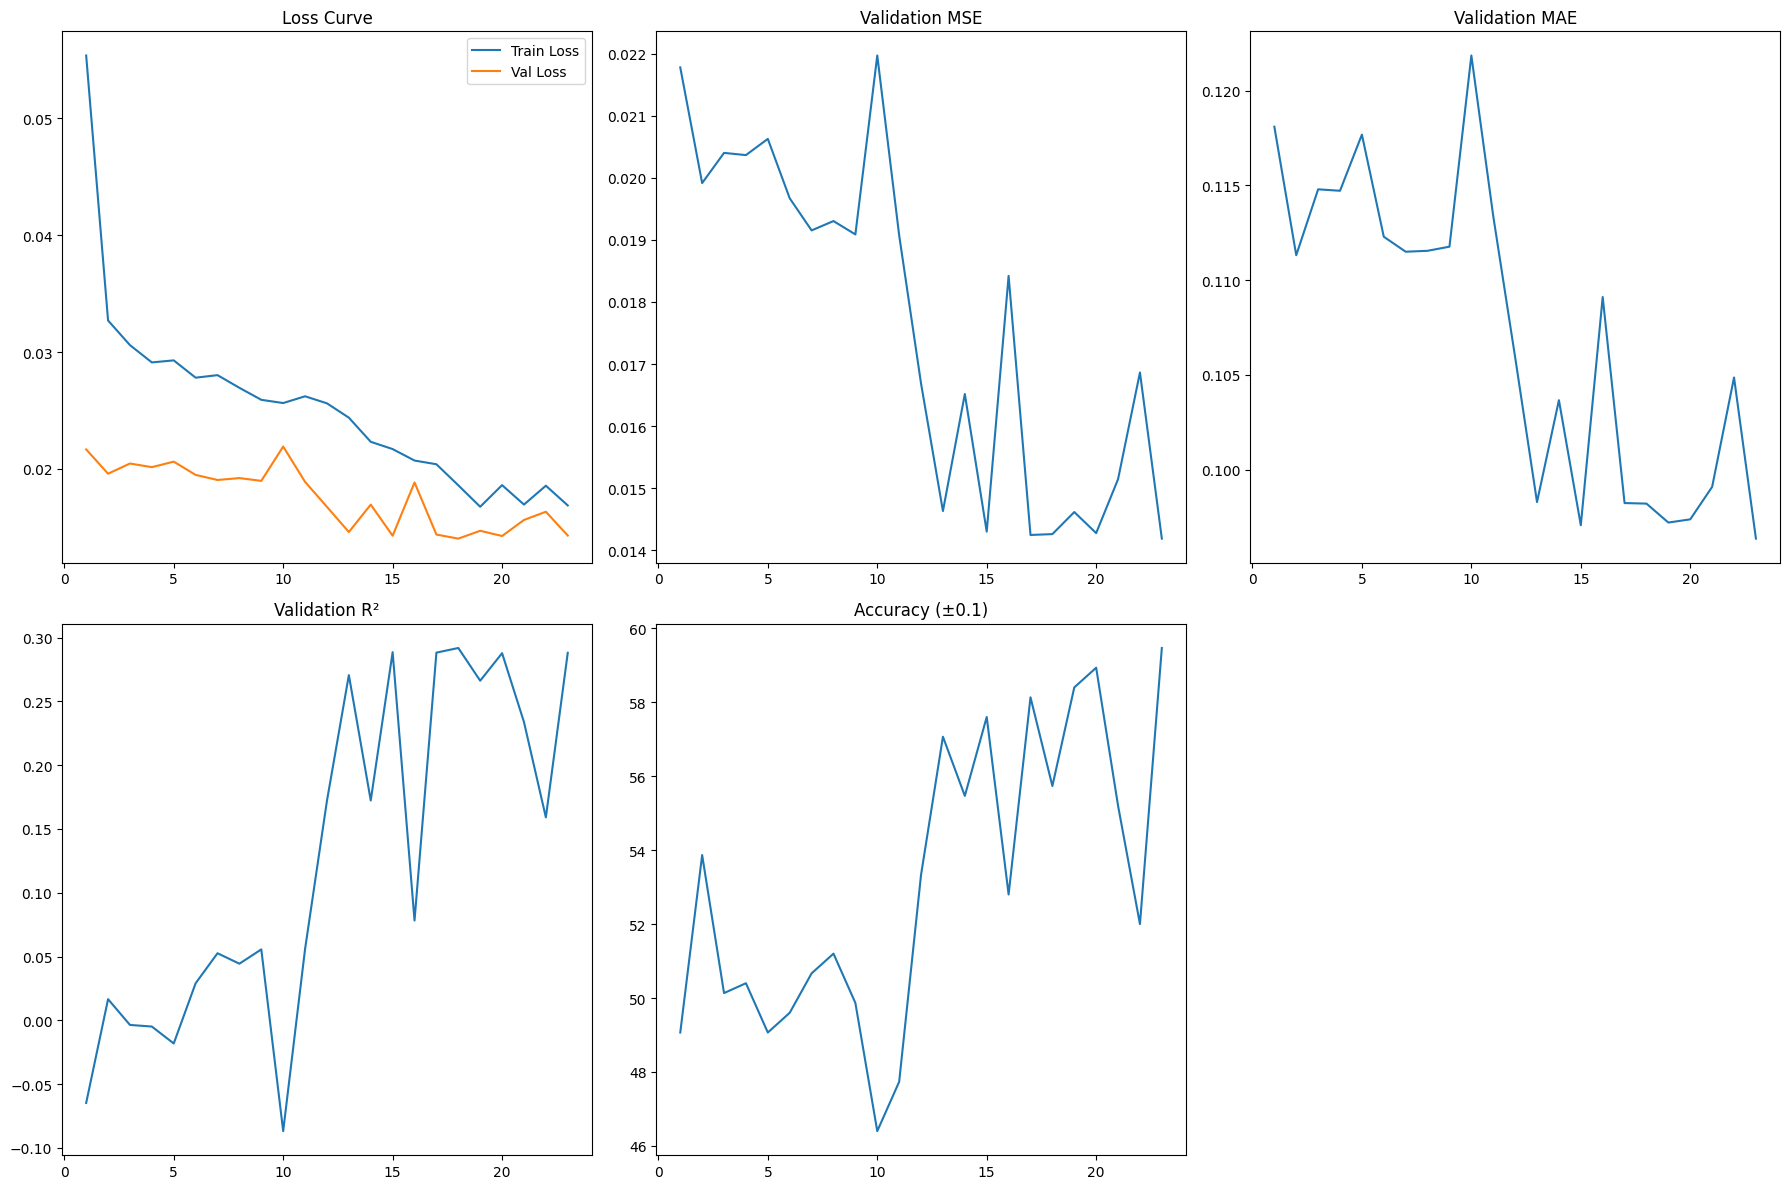


================= FINAL TEST RESULTS =================
MSE: 0.0141
MAE: 0.0937
R²:  0.2515
Accuracy ±0.1: 61.60%


In [ ]:
# ============================================================
# 📦 Install & Imports  (1D convo + Transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial (1).pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial (1).pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial (1).pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

# Convert to proper types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)

# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Conv1D + Transformer Model
# ============================================================
class OceanConvTransformer(nn.Module):
    def __init__(self, input_dim=1291, d_model=256, nhead=8,
                 num_layers=3, dim_feedforward=512, dropout=0.2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        # Local temporal modeling
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, _ = x.shape

        x = self.input_proj(x)

        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)

        cls_tok = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_tok, x], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        x = self.encoder(x, src_key_padding_mask=key_mask)
        cls_out = x[:, 0]
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Store Metrics for Graph Plotting
# ============================================================
train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []


# ============================================================
# 🏋️ Training Loop
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanConvTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)

        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)

# ============================================================
# 📈 PLOT GRAPHS
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

# MSE
plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

# MAE
plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

# R²
plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

# Accuracy
plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy (±0.1)")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 FINAL TEST EVALUATION
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (32, 1291)
Example y: [0.58878505 0.6043956  0.8446602  0.8125     0.65555555]
Example id: 1mHjMNZZvFo.004.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1 | Train 0.0543 | Val 0.0251 | MSE 0.0238 | MAE 0.1270 | R² -0.0812 | Acc±0.1 45.33%
Epoch 2 | Train 0.0347 | Val 0.0253 | MSE 0.0245 | MAE 0.1279 | R² -0.1148 | Acc±0.1 44.53%
Epoch 3 | Train 0.0314 | Val 0.0286 | MSE 0.0269 | MAE 0.1362 | R² -0.2449 | Acc±0.1 40.80%
Epoch 4 | Train 0.0298 | Val 0.0244 | MSE 0.0236 | MAE 0.1247 | R² -0.0641 | Acc±0.1 45.33%
Epoch 5 | Train 0.0290 | Val 0.0240 | MSE 0.0234 | MAE 0.1233 | R² -0.0577 | Acc±0.1 48.00%
Epoch 6 | Train 0.0271 | Val 0.0233 | MSE 0.0225 | MAE 0.1226 | R² -0.0164 | Acc±0.1 44.27%
Epoch 7 | Train 0.0266 | Val 0.0247 | MSE 0.0234 | MAE 0.1253 | R² -0.0587 | Acc±0.1 44.27%
Epoch 8 | Train 0.0273 | Val 0.0228 | MSE 0.0223 | MAE 0.1212 | R² -0.0081 | Acc±0.1 46.40%
Epoch 9 | Train 0.0261 | Val 0.0258 | MSE 0.0259 | MAE 0.1251 | R² -0.1808 | Acc±0.1 47.47%
Epoch 10 | Train 0.0263 | Val 0.0182 | MSE 0.0181 | MAE 0.1088 | R² 0.1844 | Acc±0.1 52.53%
Epoch 11 | Train 0.0257 | Val 0.0254 | MSE 0.0243 | MAE 0.1272 | R² -0.1050 | Ac

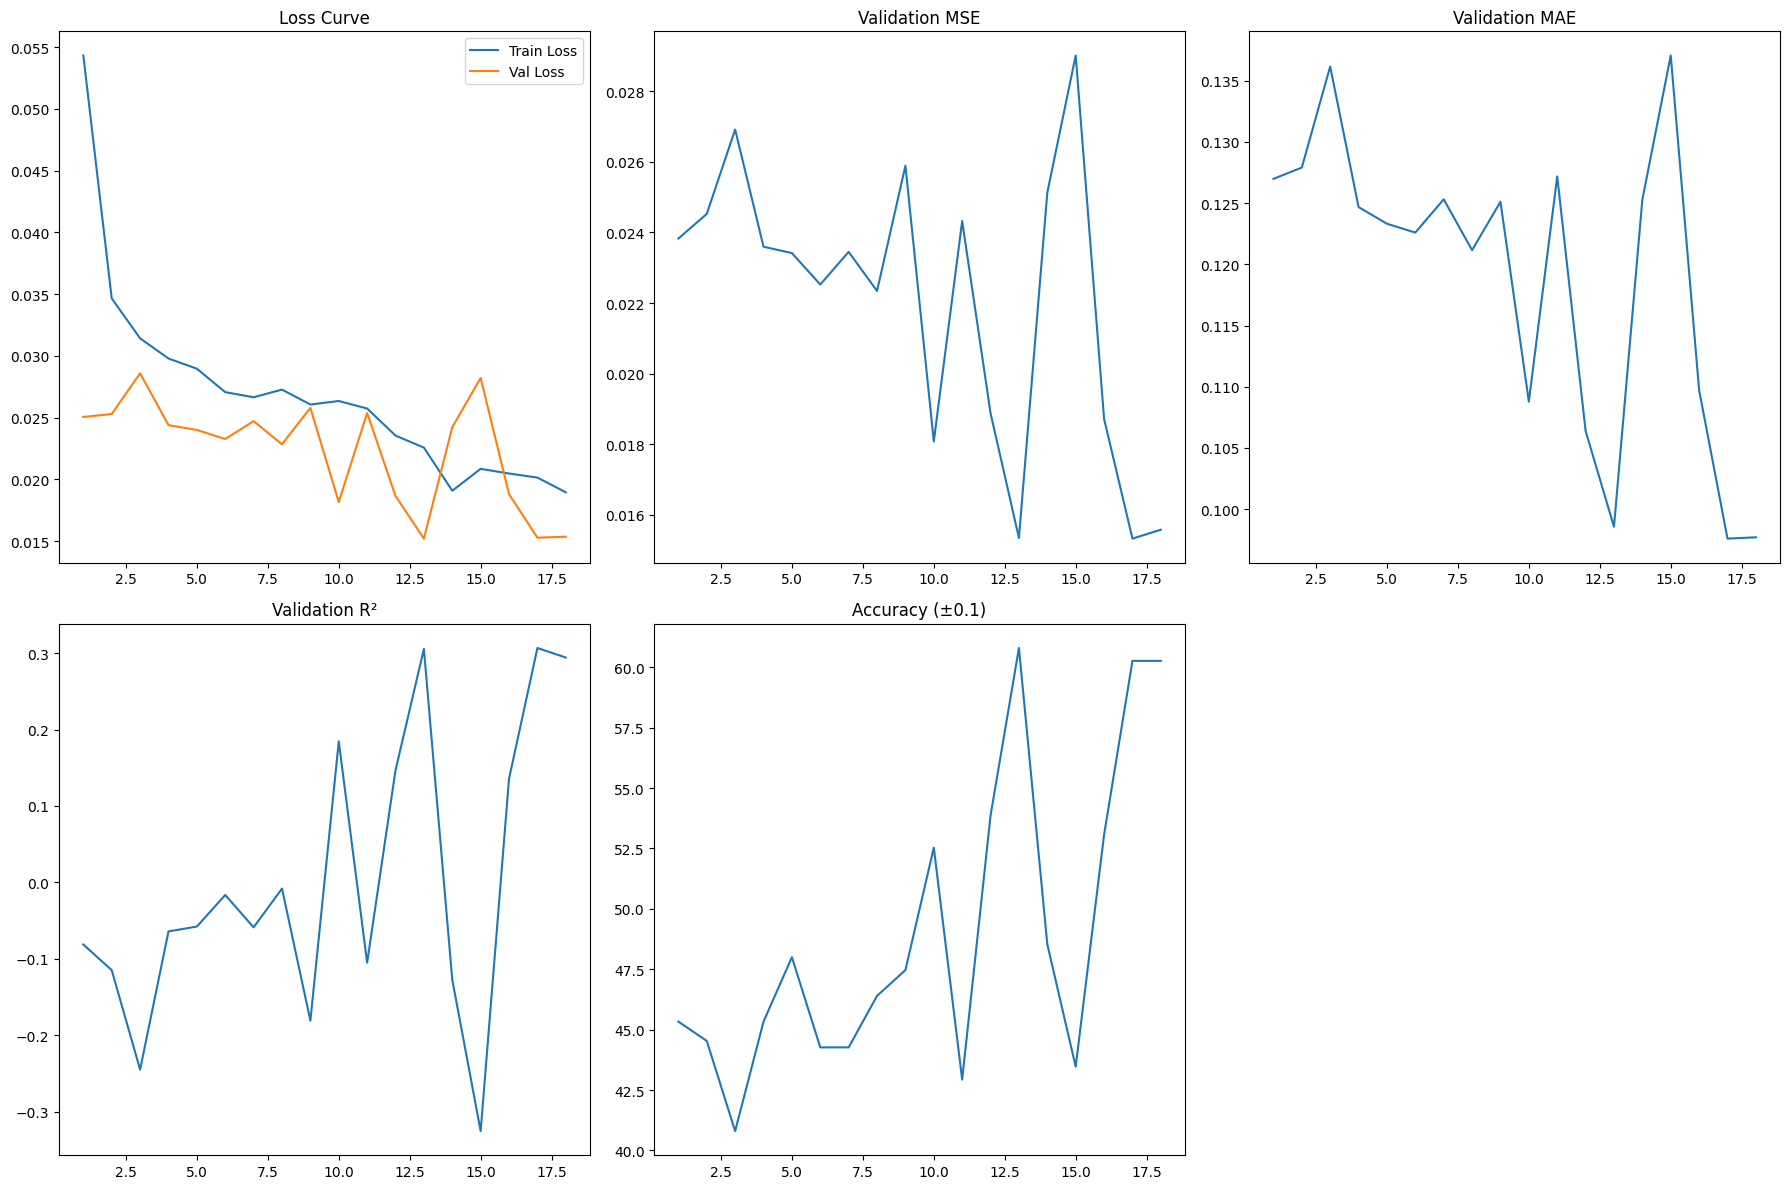


================= FINAL TEST RESULTS =================
MSE: 0.0154
MAE: 0.0969
R²:  0.0594
Accuracy ±0.1: 59.20%


In [ ]:
# ============================================================
# 📦 Install & Imports   (gru + transformer + endcoder)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial (1).pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial (1).pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial (1).pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

# Convert to proper types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)

# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Conv1D + Transformer Model
# ============================================================
class OceanConvTransformer(nn.Module):
    def __init__(self, input_dim=1291, d_model=256, nhead=8,
                 num_layers=3, dim_feedforward=512, dropout=0.2):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        # Local temporal modeling
        self.conv = nn.Sequential(
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 3, padding=1),
            nn.ReLU(),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),
        )

    def forward(self, x, mask):
        B, T, _ = x.shape

        x = self.input_proj(x)

        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)

        cls_tok = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_tok, x], dim=1)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)
        key_mask = (full_mask == 0)

        x = self.encoder(x, src_key_padding_mask=key_mask)
        cls_out = x[:, 0]
        return self.head(cls_out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Store Metrics for Graph Plotting
# ============================================================
train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []


# ============================================================
# 🏋️ Training Loop
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanConvTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS + 1):
    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)

        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)

# ============================================================
# 📈 PLOT GRAPHS
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

# MSE
plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

# MAE
plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

# R²
plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

# Accuracy
plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy (±0.1)")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 FINAL TEST EVALUATION
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (32, 1291)
Example y: [0.58878505 0.6043956  0.8446602  0.8125     0.65555555]
Example id: 1mHjMNZZvFo.004.mp4
Train: 350 | Val: 75 | Test: 75
Using: cuda
Epoch 1 | Train 0.0546 | Val 0.0240 | MSE 0.0233 | MAE 0.1192 | R² -0.1927 | Acc±0.1 51.20%
Epoch 2 | Train 0.0327 | Val 0.0194 | MSE 0.0191 | MAE 0.1093 | R² 0.0184 | Acc±0.1 52.53%
Epoch 3 | Train 0.0301 | Val 0.0220 | MSE 0.0214 | MAE 0.1148 | R² -0.0996 | Acc±0.1 53.33%
Epoch 4 | Train 0.0279 | Val 0.0189 | MSE 0.0191 | MAE 0.1087 | R² 0.0195 | Acc±0.1 54.93%
Epoch 5 | Train 0.0268 | Val 0.0212 | MSE 0.0208 | MAE 0.1120 | R² -0.0669 | Acc±0.1 53.87%
Epoch 6 | Train 0.0230 | Val 0.0199 | MSE 0.0199 | MAE 0.1089 | R² -0.0206 | Acc±0.1 54.93%
Epoch 7 | Train 0.0229 | Val 0.0176 | MSE 0.0183 | MAE 0.1057 | R² 0.0601 | Acc±0.1 58.13%
Epoch 8 |

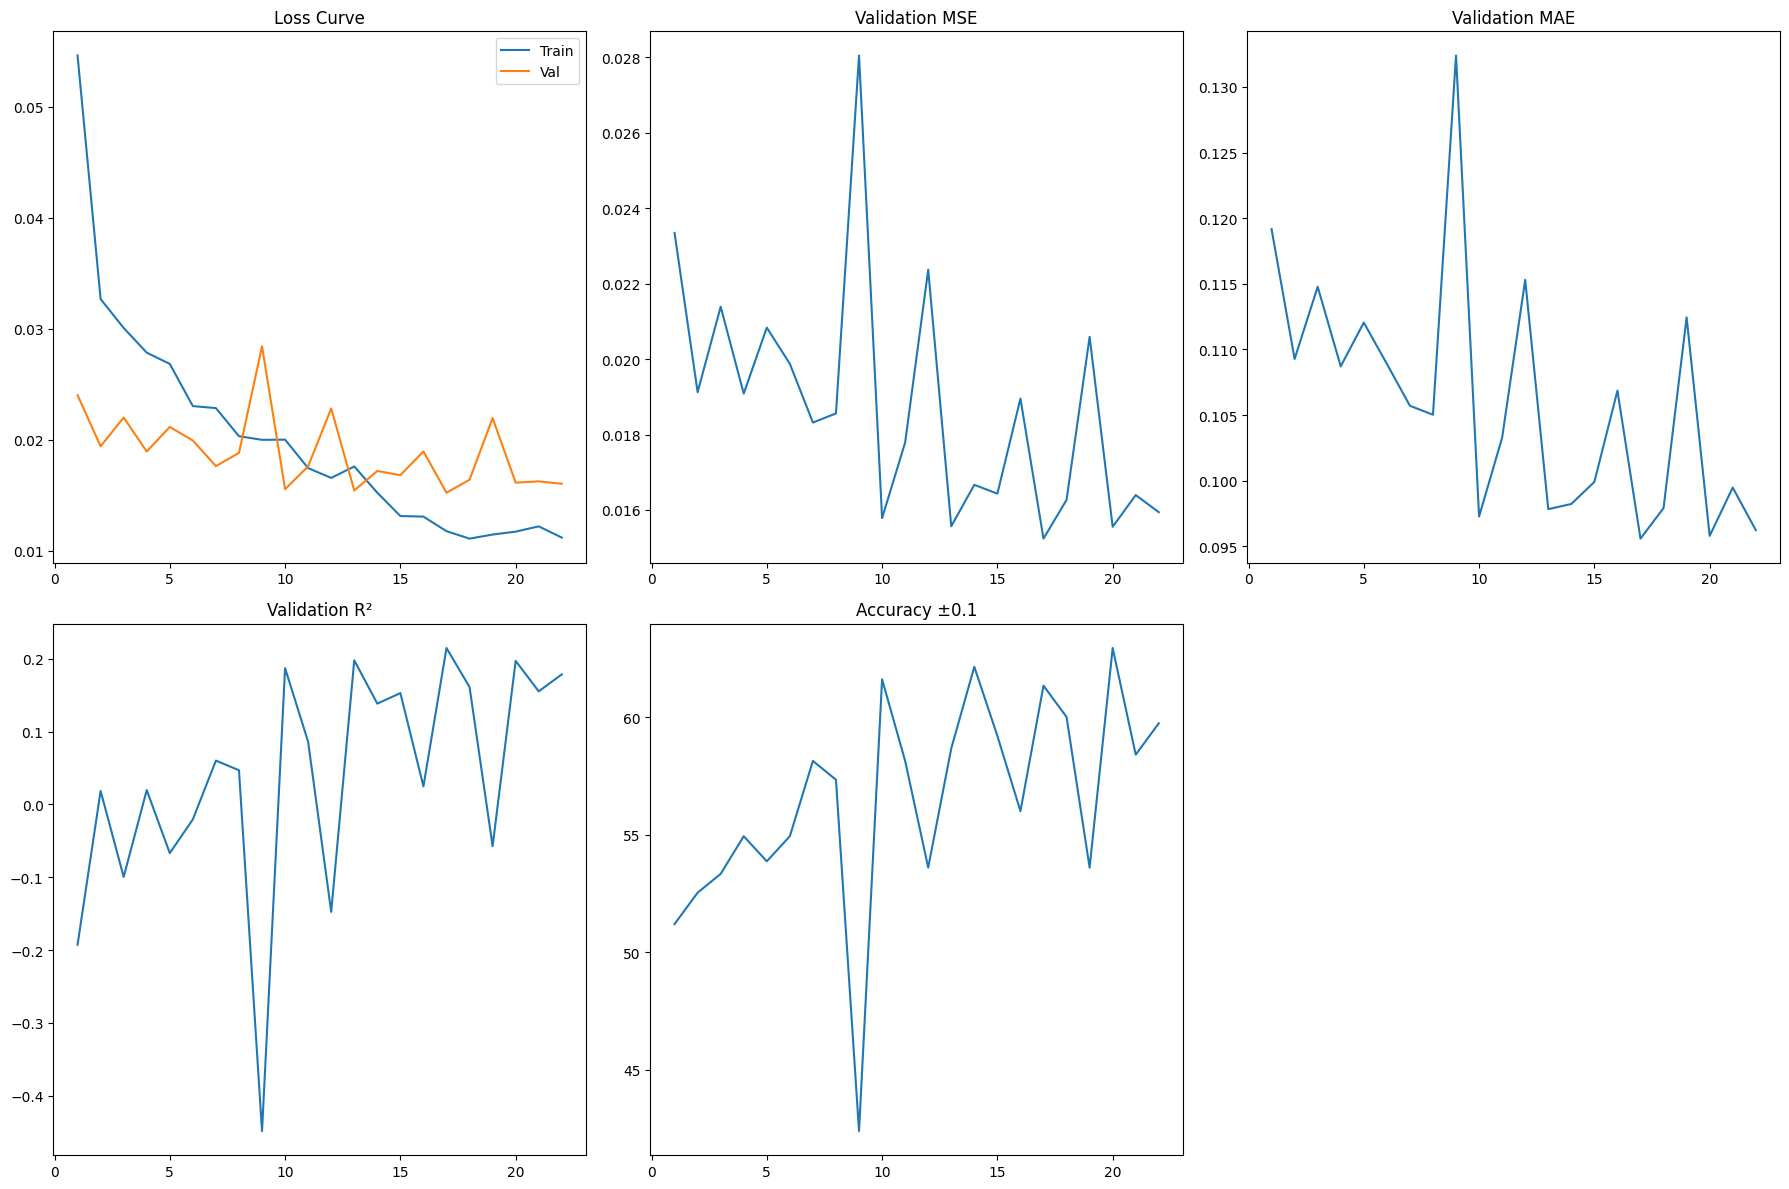


================= FINAL TEST RESULTS =================
MSE: 0.0186
MAE: 0.1094
R²:  0.1113
Accuracy ±0.1: 52.80%


In [ ]:
# ============================================================
# 📦 Install & Imports  (HCAFT)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Paths
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial (1).pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial (1).pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial (1).pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

# Convert to correct types
seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)  # (T, 1291)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 🧾 Dataset + Collate
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train / Val / Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 HCAFT: Encoders + Cross-Attention + BiGRU + Transformer
# ============================================================
class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention block:
    Q attends to K,V using MultiheadAttention.
    """
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=nhead, dropout=dropout, batch_first=True)
        self.ln = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim),
        )
        self.ff_ln = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        # q,k,v: (B, T, dim)
        attn_out, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln(q + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ff_ln(x + self.dropout(ff_out))
        return x


class OceanHCAFT(nn.Module):
    def __init__(
        self,
        input_dim=1291,
        clip_dim=512,
        fer_dim=7,
        wav_dim=768,
        prosody_dim=4,
        clip_enc_dim=128,
        fer_enc_dim=32,
        wav_enc_dim=128,
        prosody_enc_dim=16,
        d_model=256,
        nhead_xattn=4,
        nhead_transformer=8,
        num_layers_transformer=2,
        dim_feedforward=512,
        dropout=0.2,
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # -------------------------
        # 🔹 1. Modality Encoders (frame-level)
        # -------------------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(clip_enc_dim),
        )

        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(fer_enc_dim),
        )

        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(wav_enc_dim),
        )

        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim),
            nn.ReLU(),
            nn.LayerNorm(prosody_enc_dim),
        )

        # -------------------------
        # 🔹 2. Cross-Attention Fusion (frame-level)
        # CLIP ↔ Audio (Wav2Vec2)
        # -------------------------
        # Q = CLIP, K,V = Audio
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead=nhead_xattn, dropout=dropout)
        # Q = Audio, K,V = CLIP
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead=nhead_xattn, dropout=dropout)

        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # -------------------------
        # 🔹 3. BiGRU (segment / local temporal modeling)
        # -------------------------
        self.bigru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.gru_ln = nn.LayerNorm(d_model)

        # -------------------------
        # 🔹 4. Video-level Transformer
        # -------------------------
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead_transformer,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_transformer)

        # -------------------------
        # 🔹 5. OCEAN Regression Head
        # -------------------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5),   # O, C, E, A, N
        )

    def forward(self, x, mask):
        """
        x:    (B, T, 1291)
        mask: (B, T) with 1 for valid, 0 for padded
        """
        B, T, D = x.shape

        # -------------------------
        # Split modalities
        # -------------------------
        x_clip = x[:, :, 0:self.clip_dim]  # (B, T, 512)
        x_fer  = x[:, :, self.clip_dim:self.clip_dim + self.fer_dim]  # (B, T, 7)
        x_wav  = x[:, :, self.clip_dim + self.fer_dim:self.clip_dim + self.fer_dim + self.wav_dim]  # (B, T, 768)
        x_pros = x[:, :, -self.prosody_dim:]  # (B, T, 4)

        # -------------------------
        # Frame-level encoding
        # -------------------------
        e_clip = self.clip_encoder(x_clip)    # (B, T, clip_enc_dim)
        e_fer  = self.fer_encoder(x_fer)      # (B, T, fer_enc_dim)
        e_wav  = self.wav_encoder(x_wav)      # (B, T, wav_enc_dim)
        e_pros = self.prosody_encoder(x_pros) # (B, T, prosody_enc_dim)

        # -------------------------
        # Cross-Attention: CLIP ↔ Audio
        # -------------------------
        # Prepare key padding masks: True where PAD
        key_padding = (mask == 0)  # (B, T)

        # CLIP attends to Audio
        clip_from_audio = self.cross_clip_from_audio(
            q=e_clip,
            k=e_wav,
            v=e_wav,
            key_padding_mask=key_padding
        )  # (B, T, clip_enc_dim)

        # Audio attends to CLIP
        audio_from_clip = self.cross_audio_from_clip(
            q=e_wav,
            k=e_clip,
            v=e_clip,
            key_padding_mask=key_padding
        )  # (B, T, wav_enc_dim)

        # Fuse all enriched features
        fused = torch.cat(
            [clip_from_audio, audio_from_clip, e_fer, e_pros],
            dim=-1
        )  # (B, T, fused_dim)

        fused = self.fuse_proj(fused)  # (B, T, d_model)

        # -------------------------
        # BiGRU for local temporal modeling
        # -------------------------
        gru_out, _ = self.bigru(fused)  # (B, T, d_model) since bidirectional
        gru_out = self.gru_ln(gru_out)

        # -------------------------
        # Video-level Transformer with [CLS]
        # -------------------------
        cls_tok = self.cls_token.expand(B, 1, -1)  # (B, 1, d_model)
        seq = torch.cat([cls_tok, gru_out], dim=1)  # (B, T+1, d_model)

        cls_mask = torch.ones(B, 1, device=mask.device)
        full_mask = torch.cat([cls_mask, mask], dim=1)  # (B, T+1)
        key_padding_mask = (full_mask == 0)  # True where pad

        enc = self.encoder(seq, src_key_padding_mask=key_padding_mask)  # (B, T+1, d_model)
        cls_out = enc[:, 0]  # (B, d_model)

        # -------------------------
        # OCEAN prediction
        # -------------------------
        out = self.head(cls_out)  # (B, 5)
        return out


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 📈 Training Setup
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

model = OceanHCAFT(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []

val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

# ============================================================
# 🏋️ Training Loop
# ============================================================
for epoch in range(1, EPOCHS + 1):

    # -------- TRAIN --------
    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- VALIDATION --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
            preds = model(x, mask)

            loss = criterion(preds, y)
            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_history, label="Train")
plt.plot(epochs, val_loss_history, label="Val")
plt.title("Loss Curve")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_mse_history)
plt.title("Validation MSE")

plt.subplot(2, 3, 3)
plt.plot(epochs, val_mae_history)
plt.title("Validation MAE")

plt.subplot(2, 3, 4)
plt.plot(epochs, val_r2_history)
plt.title("Validation R²")

plt.subplot(2, 3, 5)
plt.plot(epochs, val_acc_history)
plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)
        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PKL feature files...
✅ Loaded 500 videos
Example X shape: (32, 1291)
Example y: [0.58878505 0.6043956  0.8446602  0.8125     0.65555555]
Example id: 1mHjMNZZvFo.004.mp4
Train: 350 | Val: 75 | Test: 75
Epoch 1 | Train 0.0537 | Val 0.0188 | MSE 0.0190 | MAE 0.1120 | R² -0.0724 | Acc±0.1 51.20%
Epoch 2 | Train 0.0333 | Val 0.0181 | MSE 0.0185 | MAE 0.1088 | R² -0.0410 | Acc±0.1 54.40%
Epoch 3 | Train 0.0298 | Val 0.0195 | MSE 0.0197 | MAE 0.1137 | R² -0.1071 | Acc±0.1 52.00%
Epoch 4 | Train 0.0287 | Val 0.0180 | MSE 0.0183 | MAE 0.1073 | R² -0.0274 | Acc±0.1 54.93%
Epoch 5 | Train 0.0265 | Val 0.0197 | MSE 0.0204 | MAE 0.1126 | R² -0.1465 | Acc±0.1 56.00%
Epoch 6 | Train 0.0242 | Val 0.0203 | MSE 0.0210 | MAE 0.1139 | R² -0.1826 | Acc±0.1 54.93%
Epoch 7 | Train 0.0219 | Val 0.0190 | MSE 0.0195 | MAE 0.1090 | R² -0.1039 | Acc±0.1 54.67%
Epoch 8 | Train 0.

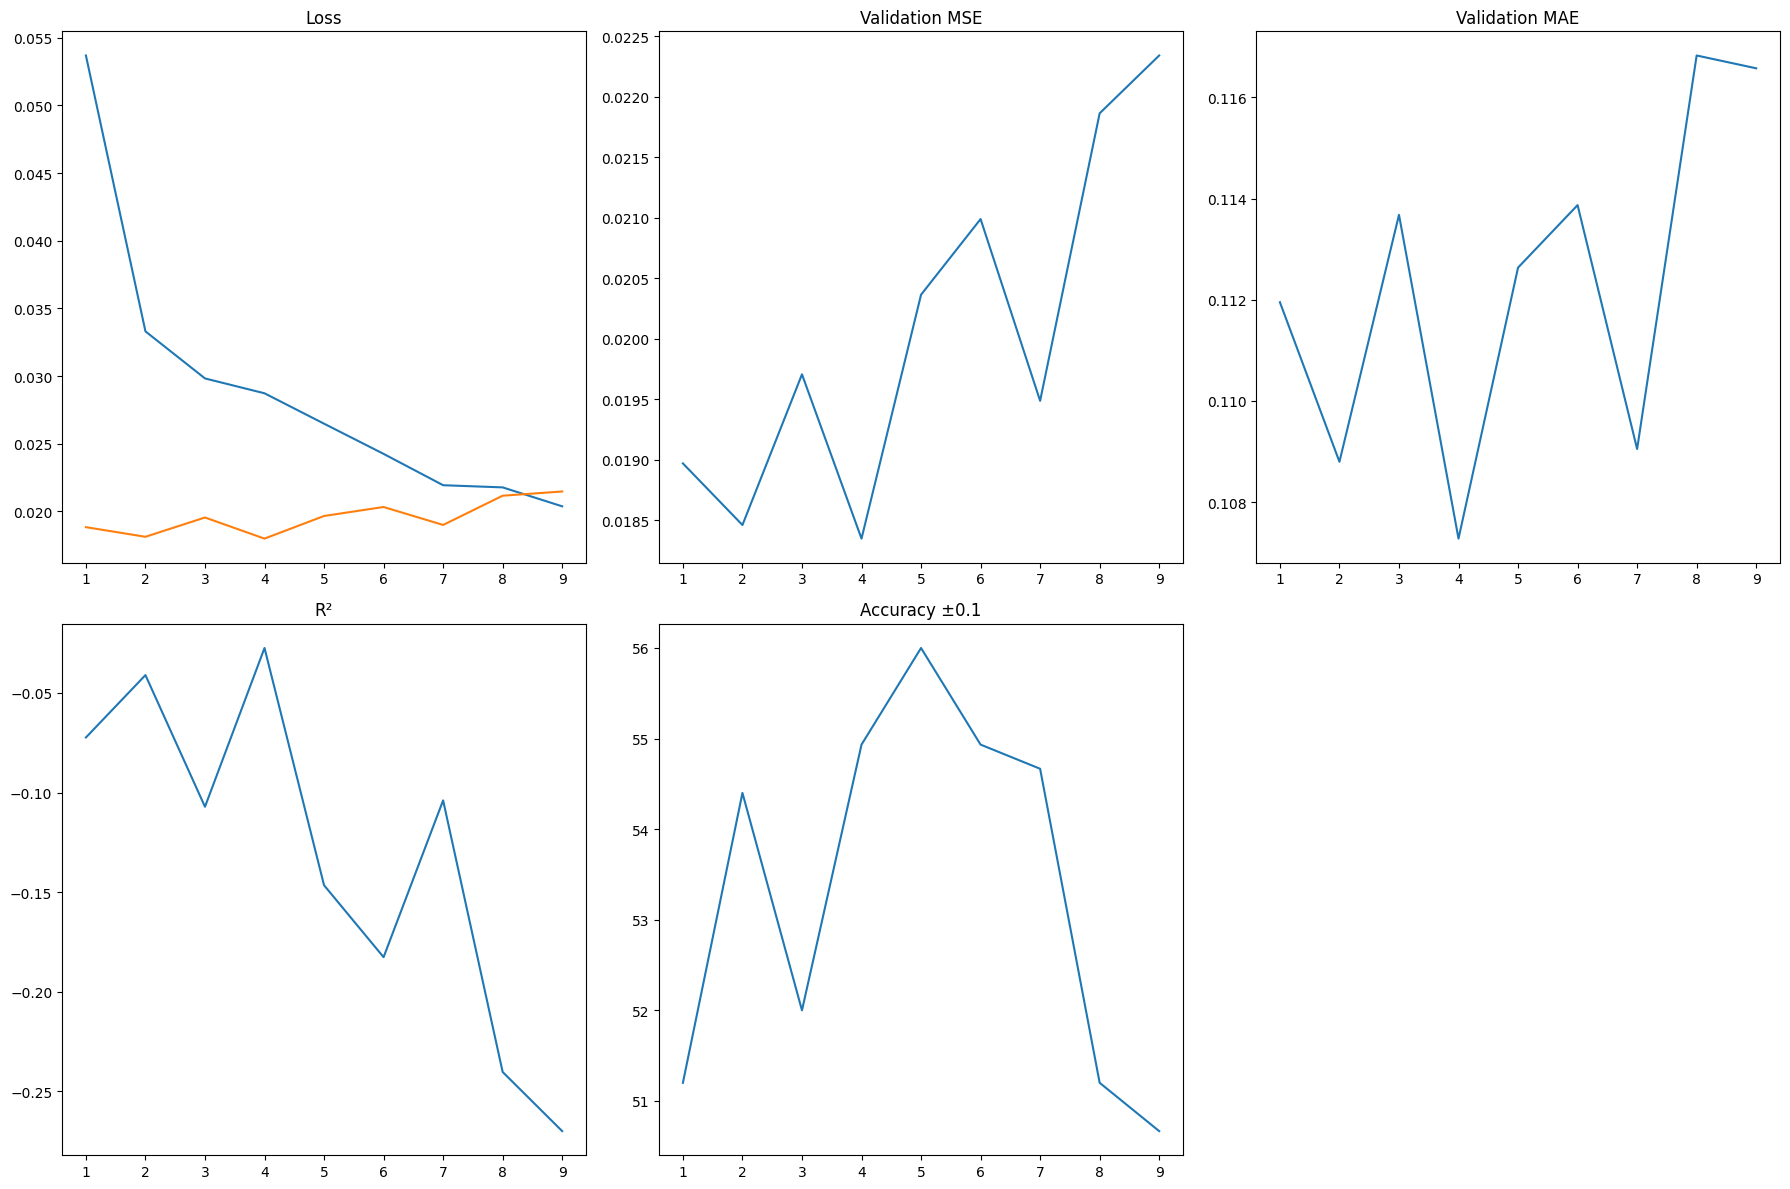


================= FINAL TEST RESULTS =================
MSE: 0.0157
MAE: 0.1022
R²:  0.2247
Accuracy ±0.1: 57.33%


In [ ]:
# ============================================================
# 📦 Install & Imports (BiLSTM + Transformer)
# ============================================================
!pip install -q scikit-learn

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 📂 Load Feature Files
# ============================================================
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project"

seq_X_path  = os.path.join(FEATURE_DIR, "seq_X_partial (1).pkl")
seq_y_path  = os.path.join(FEATURE_DIR, "seq_y_partial (1).pkl")
seq_id_path = os.path.join(FEATURE_DIR, "seq_id_partial (1).pkl")

print("Loading PKL feature files...")

with open(seq_X_path, "rb") as f:
    seq_X_raw = pickle.load(f)

with open(seq_y_path, "rb") as f:
    seq_y = pickle.load(f)

with open(seq_id_path, "rb") as f:
    seq_id = pickle.load(f)

seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
seq_y = np.array(seq_y, dtype=np.float32)
seq_id = np.array(seq_id)

N = len(seq_X)
INPUT_DIM = seq_X[0].shape[1]

print(f"✅ Loaded {N} videos")
print("Example X shape:", seq_X[0].shape)
print("Example y:", seq_y[0])
print("Example id:", seq_id[0])


# ============================================================
# 📦 Dataset + Collate fn
# ============================================================
class OceanDataset(Dataset):
    def __init__(self, X_list, y_array, ids):
        self.X_list = X_list
        self.y_array = y_array
        self.ids = ids

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return {
            "x": torch.tensor(self.X_list[idx], dtype=torch.float32),
            "y": torch.tensor(self.y_array[idx], dtype=torch.float32),
            "id": self.ids[idx],
        }

def collate_fn(batch):
    xs  = [item["x"] for item in batch]
    ys  = [item["y"] for item in batch]
    ids = [item["id"] for item in batch]

    lengths = [x.shape[0] for x in xs]
    max_len = max(lengths)
    feat_dim = xs[0].shape[1]
    B = len(xs)

    padded_x = torch.zeros(B, max_len, feat_dim)
    mask = torch.zeros(B, max_len)

    for i, x in enumerate(xs):
        T = x.shape[0]
        padded_x[i, :T] = x
        mask[i, :T] = 1

    y = torch.stack(ys, dim=0)
    return {"x": padded_x, "y": y, "mask": mask, "id": ids}

dataset = OceanDataset(seq_X, seq_y, seq_id)


# ============================================================
# 📊 Train/Val/Test Split
# ============================================================
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


# ============================================================
# 🧠 Cross-Attention Block
# ============================================================
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, nhead=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(dim, nhead, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, dim)
        )
        self.ln2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, key_padding_mask=None):
        attn, _ = self.mha(q, k, v, key_padding_mask=key_padding_mask)
        x = self.ln1(q + self.dropout(attn))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x


# ============================================================
# 🧠 BiLSTM + Transformer Multimodal Model
# ============================================================
class OceanBiLSTMTransformer(nn.Module):
    def __init__(self,
                 input_dim=1291,
                 clip_dim=512,
                 fer_dim=7,
                 wav_dim=768,
                 prosody_dim=4,
                 clip_enc_dim=128,
                 fer_enc_dim=32,
                 wav_enc_dim=128,
                 prosody_enc_dim=16,
                 d_model=256,
                 dropout=0.2,
                 nhead_xattn=4,
                 nhead_transformer=8,
                 num_layers_transformer=2):
        super().__init__()

        self.clip_dim = clip_dim
        self.fer_dim = fer_dim
        self.wav_dim = wav_dim
        self.prosody_dim = prosody_dim

        # ------------ Encoders -------------
        self.clip_encoder = nn.Sequential(
            nn.Linear(clip_dim, clip_enc_dim), nn.ReLU(), nn.LayerNorm(clip_enc_dim)
        )
        self.fer_encoder = nn.Sequential(
            nn.Linear(fer_dim, fer_enc_dim), nn.ReLU(), nn.LayerNorm(fer_enc_dim)
        )
        self.wav_encoder = nn.Sequential(
            nn.Linear(wav_dim, wav_enc_dim), nn.ReLU(), nn.LayerNorm(wav_enc_dim)
        )
        self.prosody_encoder = nn.Sequential(
            nn.Linear(prosody_dim, prosody_enc_dim), nn.ReLU(), nn.LayerNorm(prosody_enc_dim)
        )

        # ------------ Cross Attention -------------
        self.cross_clip_from_audio = CrossAttentionBlock(clip_enc_dim, nhead_xattn, dropout)
        self.cross_audio_from_clip = CrossAttentionBlock(wav_enc_dim, nhead_xattn, dropout)

        fused_dim = clip_enc_dim + wav_enc_dim + fer_enc_dim + prosody_enc_dim

        self.fuse_proj = nn.Sequential(
            nn.Linear(fused_dim, d_model),
            nn.ReLU(),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
        )

        # ------------ BiLSTM -------------
        self.bilstm = nn.LSTM(
            d_model, d_model//2,
            batch_first=True,
            bidirectional=True
        )
        self.lstm_ln = nn.LayerNorm(d_model)

        # ------------ Transformer -------------
        self.cls_token = nn.Parameter(torch.randn(1,1,d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead_transformer,
            dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers_transformer)

        # ------------ Regression Head -------------
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 5)
        )

    def forward(self, x, mask):
        B, T, D = x.shape

        # Split modalities
        x_clip = x[:, :, :self.clip_dim]
        x_fer  = x[:, :, self.clip_dim:self.clip_dim+self.fer_dim]
        x_wav  = x[:, :, self.clip_dim+self.fer_dim:self.clip_dim+self.fer_dim+self.wav_dim]
        x_pros = x[:, :, -self.prosody_dim:]

        # Encode
        e_clip = self.clip_encoder(x_clip)
        e_fer  = self.fer_encoder(x_fer)
        e_wav  = self.wav_encoder(x_wav)
        e_pros = self.prosody_encoder(x_pros)

        padding_mask = (mask==0)

        # Cross attention
        clip_ca = self.cross_clip_from_audio(e_clip, e_wav, e_wav, key_padding_mask=padding_mask)
        wav_ca  = self.cross_audio_from_clip(e_wav, e_clip, e_clip, key_padding_mask=padding_mask)

        fused = torch.cat([clip_ca, wav_ca, e_fer, e_pros], dim=-1)
        fused = self.fuse_proj(fused)

        # BiLSTM
        lstm_out, _ = self.bilstm(fused)
        lstm_out = self.lstm_ln(lstm_out)

        # Transformer w/ CLS
        cls = self.cls_token.expand(B,1,-1)
        seq = torch.cat([cls, lstm_out], dim=1)

        full_mask = torch.cat([torch.ones(B,1,device=mask.device), mask], dim=1)
        key_mask = (full_mask==0)

        enc = self.encoder(seq, src_key_padding_mask=key_mask)
        out = enc[:,0]

        return self.head(out)


# ============================================================
# 📏 Metrics
# ============================================================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    acc = ((np.abs(y_true - y_pred) <= 0.1).mean()) * 100
    return mse, mae, r2, acc


# ============================================================
# 🏋️ Training
# ============================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = OceanBiLSTMTransformer(input_dim=INPUT_DIM).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()

train_loss_history = []
val_loss_history   = []
val_mse_history = []
val_mae_history = []
val_r2_history  = []
val_acc_history = []

best_val = float("inf")
patience = 5
pat_ctr = 0
EPOCHS = 25

for epoch in range(1, EPOCHS+1):

    model.train()
    train_losses = []

    for batch in train_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

        optimizer.zero_grad()
        preds = model(x, mask)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train = np.mean(train_losses)
    train_loss_history.append(avg_train)

    # -------- Validation --------
    model.eval()
    val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)

            preds = model(x, mask)
            loss = criterion(preds, y)

            val_losses.append(loss.item())

            y_true.append(y.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    avg_val = np.mean(val_losses)
    val_loss_history.append(avg_val)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    mse, mae, r2, acc = compute_metrics(y_true, y_pred)

    val_mse_history.append(mse)
    val_mae_history.append(mae)
    val_r2_history.append(r2)
    val_acc_history.append(acc)

    print(f"Epoch {epoch} | Train {avg_train:.4f} | Val {avg_val:.4f} | "
          f"MSE {mse:.4f} | MAE {mae:.4f} | R² {r2:.4f} | Acc±0.1 {acc:.2f}%")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        best_state = model.state_dict()
        pat_ctr = 0
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)


# ============================================================
# 📈 Plot Metrics
# ============================================================
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(18, 12))

plt.subplot(2,3,1); plt.plot(epochs, train_loss_history); plt.plot(epochs, val_loss_history); plt.title("Loss")
plt.subplot(2,3,2); plt.plot(epochs, val_mse_history); plt.title("Validation MSE")
plt.subplot(2,3,3); plt.plot(epochs, val_mae_history); plt.title("Validation MAE")
plt.subplot(2,3,4); plt.plot(epochs, val_r2_history); plt.title("R²")
plt.subplot(2,3,5); plt.plot(epochs, val_acc_history); plt.title("Accuracy ±0.1")

plt.tight_layout()
plt.show()


# ============================================================
# 🧪 Final Test Evaluation
# ============================================================
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for batch in test_loader:
        x, y, mask = batch["x"].to(DEVICE), batch["y"].to(DEVICE), batch["mask"].to(DEVICE)
        preds = model(x, mask)

        true_list.append(y.cpu().numpy())
        pred_list.append(preds.cpu().numpy())

true_list = np.vstack(true_list)
pred_list = np.vstack(pred_list)

mse, mae, r2, acc = compute_metrics(true_list, pred_list)

print("\n================= FINAL TEST RESULTS =================")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")
print(f"Accuracy ±0.1: {acc:.2f}%")


In [3]:
import numpy as np
import os
import sys

# --- Define Paths ---
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project/MLP_Classifier"

# Path to your final 1000-row OCEAN score ground truth array (the input for the mapping)
y_ocean_path = os.path.join(FEATURE_DIR, "seq_y (1).npy")

# Output path for the new 4-trait MBTI binary label array
mbti_y_path = os.path.join(FEATURE_DIR, "seq_y_mbti.npy")

# --- 1. Load OCEAN Ground Truth ---
print("--- Loading OCEAN Ground Truth Scores ---")
try:
    # Load the (1000, 5) array of true OCEAN scores
    seq_y_ocean = np.load(y_ocean_path)
    N = len(seq_y_ocean)
    if seq_y_ocean.shape[1] != 5:
        raise ValueError(f"Expected 5 columns, found {seq_y_ocean.shape[1]}")

    # 🚨 CRITICAL CHECK: Determine the order of the 5 traits in your array
    # We assume the order is: [Openness (O), Conscientiousness (C), Extraversion (E), Agreeableness (A), Neuroticism (N)]
    O_IDX = 0 # Maps to N/S
    C_IDX = 1 # Maps to J/P
    E_IDX = 2 # Maps to E/I
    A_IDX = 3 # Maps to F/T (Feeling/Thinking)
    N_IDX = 4 # Not used in this primary mapping

    print(f"✅ Loaded {N} videos with OCEAN scores.")
    print(f"   Assumed order: O({O_IDX}), C({C_IDX}), E({E_IDX}), A({A_IDX}), N({N_IDX})")

except Exception as e:
    print(f"❌ ERROR loading OCEAN data from {y_ocean_path}: {e}. Exiting.")
    sys.exit()

# --- 2. Define Mapping Parameters ---
# MBTI output order: [E/I, S/N, T/F, J/P]
mbti_labels = np.zeros((N, 4), dtype=np.float32)
THRESHOLD = 0.5
print(f"Applying binary mapping using a threshold of {THRESHOLD}...")

# --- 3. Apply Threshold Mapping ---

# 1. E/I (Extraversion/Introversion) <-> Extraversion (E)
# High E (score > 0.5) maps to E (1). Low E maps to I (0).
mbti_labels[:, 0] = (seq_y_ocean[:, E_IDX] > THRESHOLD).astype(np.float32)
# Trait 1 (MBTI Index 0): E (1) or I (0)

# 2. S/N (Sensing/Intuition) <-> Openness (O)
# High O (score > 0.5) maps to N (Intuition, 1). Low O maps to S (Sensing, 0).
mbti_labels[:, 1] = (seq_y_ocean[:, O_IDX] > THRESHOLD).astype(np.float32)
# Trait 2 (MBTI Index 1): N (1) or S (0)

# 3. T/F (Thinking/Feeling) <-> Agreeableness (A)
# High A (score > 0.5) maps to F (Feeling, 1). Low A maps to T (Thinking, 0).
mbti_labels[:, 2] = (seq_y_ocean[:, A_IDX] > THRESHOLD).astype(np.float32)
# Trait 3 (MBTI Index 2): F (1) or T (0)

# 4. J/P (Judging/Perceiving) <-> Conscientiousness (C)
# High C (score > 0.5) maps to J (Judging, 1). Low C maps to P (Perceiving, 0).
mbti_labels[:, 3] = (seq_y_ocean[:, C_IDX] > THRESHOLD).astype(np.float32)
# Trait 4 (MBTI Index 3): J (1) or P (0)


# --- 4. Save the MBTI Ground Truth ---
np.save(mbti_y_path, mbti_labels)

print("\n--- Mapping Complete ---")
print(f"MBTI Label array shape: {mbti_labels.shape}")
print(f"Output MBTI order: [E/I, S/N, T/F, J/P]")
print(f"Video 1 Labels: {mbti_labels[0]}")
print(f"Saved MBTI labels to: {mbti_y_path}")

--- Loading OCEAN Ground Truth Scores ---
✅ Loaded 500 videos with OCEAN scores.
   Assumed order: O(0), C(1), E(2), A(3), N(4)
Applying binary mapping using a threshold of 0.5...

--- Mapping Complete ---
MBTI Label array shape: (500, 4)
Output MBTI order: [E/I, S/N, T/F, J/P]
Video 1 Labels: [0. 0. 0. 1.]
Saved MBTI labels to: /content/drive/MyDrive/NNdl_Project/MLP_Classifier/seq_y_mbti.npy


In [44]:
import numpy as np
import os
import sys
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# --- Define Paths ---
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project/MLP_Classifier"

# Input X for the MLP is the 5-dim OCEAN Ground Truth
y_ocean_path = os.path.join(FEATURE_DIR, "seq_y (1).npy")
# Target Y for the MLP is the 4-dim MBTI Ground Truth
mbti_y_path = os.path.join(FEATURE_DIR, "seq_y_mbti.npy")

MODEL_SAVE_PATH_MBTI = os.path.join(FEATURE_DIR, "best_mbti_mlp(1).pth") # Final MLP Checkpoint

# --- 2. Load Data ---
print("--- Loading OCEAN Input and MBTI Target Data ---")
try:
    seq_y_ocean = np.load(y_ocean_path)
    mbti_labels = np.load(mbti_y_path)
    N = len(seq_y_ocean)

    if seq_y_ocean.shape != (N, 5) or mbti_labels.shape != (N, 4):
         raise ValueError(f"Shape mismatch: OCEAN {seq_y_ocean.shape}, MBTI {mbti_labels.shape}")

    print(f"✅ Data loaded successfully. N={N} sequences.")

except Exception as e:
    print(f"❌ Error loading data: {e}. Exiting.")
    sys.exit()

# --- 3. Prepare Tensors and Split ---
ocean_input_tensor = torch.tensor(seq_y_ocean, dtype=torch.float32) # (1000, 5)
mbti_target_tensor = torch.tensor(mbti_labels, dtype=torch.float32)  # (1000, 4)

dataset = TensorDataset(ocean_input_tensor, mbti_target_tensor)

train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

# --- 4. Define the Small MLP Classifier ---
class MBTIMLPClassifier(nn.Module):
    def __init__(self, input_dim=5, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# --- 5. Training Loop ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = MBTIMLPClassifier(input_dim=5, output_dim=4).to(DEVICE)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=20e-4, weight_decay=1e-5)

best_val_loss = float("inf")
patience = 10
pat_ctr = 0
EPOCHS = 100

print(f"\nStarting MLP training on {DEVICE}...")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    # -------- Validation --------
    model.eval()
    val_loss = 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item() * x.size(0)

            y_true_val.append(y.cpu().numpy())
            y_pred_val.append((preds > 0.5).float().cpu().numpy())

    avg_train_loss = train_loss / len(train_ds)
    avg_val_loss = val_loss / len(val_ds)

    y_true_val = np.vstack(y_true_val)
    y_pred_val = np.vstack(y_pred_val)

    val_accuracy = accuracy_score(y_true_val, y_pred_val)
    val_f1_macro = f1_score(y_true_val, y_pred_val, average='macro', zero_division=0)

    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | Val F1 (Macro): {val_f1_macro:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state = model.state_dict()
        pat_ctr = 0
        torch.save(best_state, MODEL_SAVE_PATH_MBTI)
        # print(f"   💾 Best MLP model saved.")
    else:
        pat_ctr += 1
        if pat_ctr >= patience:
            print("⏹ Early stopping triggered")
            break

model.load_state_dict(best_state)

# --- 6. Final Test Evaluation ---
model.eval()
true_list, pred_list = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)

        true_list.append(y.cpu().numpy())
        pred_list.append((preds > 0.5).float().cpu().numpy())

y_true_test = np.vstack(true_list)
y_pred_test = np.vstack(pred_list)

test_accuracy = accuracy_score(y_true_test, y_pred_test)
test_f1_macro = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)
test_precision = precision_score(y_true_test, y_pred_test, average='macro', zero_division=0)
test_recall = recall_score(y_true_test, y_pred_test, average='macro', zero_division=0)


print("\n================= FINAL MBTI MLP TEST RESULTS =================")
print(f"Accuracy (Total Label Match): {test_accuracy:.4f}")
print(f"F1 Score (Macro, per trait): {test_f1_macro:.4f}")
print("=============================================================")

--- Loading OCEAN Input and MBTI Target Data ---
✅ Data loaded successfully. N=500 sequences.
Train: 350 | Val: 75 | Test: 75

Starting MLP training on cpu...
Epoch 01 | Train Loss: 0.7015 | Val Loss: 0.6938 | Val Acc: 0.0133 | Val F1 (Macro): 0.2993
Epoch 02 | Train Loss: 0.6882 | Val Loss: 0.6805 | Val Acc: 0.0400 | Val F1 (Macro): 0.2321
Epoch 03 | Train Loss: 0.6786 | Val Loss: 0.6657 | Val Acc: 0.1467 | Val F1 (Macro): 0.6074
Epoch 04 | Train Loss: 0.6649 | Val Loss: 0.6502 | Val Acc: 0.1467 | Val F1 (Macro): 0.5918
Epoch 05 | Train Loss: 0.6549 | Val Loss: 0.6347 | Val Acc: 0.1467 | Val F1 (Macro): 0.5918
Epoch 06 | Train Loss: 0.6426 | Val Loss: 0.6212 | Val Acc: 0.1467 | Val F1 (Macro): 0.5918
Epoch 07 | Train Loss: 0.6298 | Val Loss: 0.6074 | Val Acc: 0.1467 | Val F1 (Macro): 0.5949
Epoch 08 | Train Loss: 0.6167 | Val Loss: 0.5907 | Val Acc: 0.1467 | Val F1 (Macro): 0.5982
Epoch 09 | Train Loss: 0.5937 | Val Loss: 0.5715 | Val Acc: 0.2667 | Val F1 (Macro): 0.7177
Epoch 10 | Tr

In [94]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# ------------------- Auto-find files -------------------
FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project/MLP_Classifier"

def find(pats):
    for pat in pats:
        matches = [f for f in os.listdir(FEATURE_DIR) if pat in f]
        if matches:
            path = os.path.join(FEATURE_DIR, matches[0])
            print(f"Found → {matches[0]}")
            return path
    raise FileNotFoundError(pats)

X_final_path  = find(["seq_X"])
seq_id_path   = find(["seq_id"])
mbti_y_path   = find(["seq_y_mbti"])
P1_MODEL_PATH = find(["ocean_enc_bigru_trans_best"])
P2_MODEL_PATH = find(["best_mbti_mlp"])

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}\n")

# ------------------- Dataset -------------------
class TestDataset(Dataset):
    def __init__(self, seq_X):
        self.seq_X = seq_X
    def __len__(self): return len(self.seq_X)
    def __getitem__(self, idx):
        x = torch.tensor(self.seq_X[idx], dtype=torch.float32)
        mask = torch.ones(x.shape[0], dtype=torch.bool)
        return {"x": x, "mask": mask}

def collate_fn(batch):
    x = torch.nn.utils.rnn.pad_sequence([b["x"] for b in batch], batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence([b["mask"] for b in batch], batch_first=True)
    return {"x": x, "mask": mask}

# ------------------- EXACT MODEL THAT MATCHES YOUR .pth FILE -------------------
class MultimodalOCEANEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # EXACT modality encoders from your training
        self.clip_encoder    = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 128))  # → 128
        self.fer_encoder     = nn.Sequential(nn.Linear(7,   32), nn.ReLU(), nn.Linear(32,  128))  # → 128
        self.wav_encoder     = nn.Sequential(nn.Linear(768, 128), nn.ReLU(), nn.Linear(128, 128))  # → 128
        self.prosody_encoder = nn.Sequential(nn.Linear(4,   16), nn.ReLU(), nn.Linear(16,  128))  # → 128

        # Fusion: 128×4 = 512 → 256
        self.fuse_proj = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
        )

        self.bigru = nn.GRU(256, 128, batch_first=True, bidirectional=True)
        self.gru_ln = nn.LayerNorm(256)

        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512,
                                                   dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.cls_token = nn.Parameter(torch.randn(1, 1, 256))

        # Adjusted head to match the dimensions from the checkpoint and output 5 traits
        self.head = nn.Sequential(
            nn.LayerNorm(256),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 5)   # ← Adjusted to match 5 traits for OCEAN
        )

    def forward(self, x, mask):
        B, L, _ = x.shape

        # Split the input into modalities
        clip    = x[:, :, :512]
        fer     = x[:, :, 512:519]
        wav     = x[:, :, 519:1287]
        prosody = x[:, :, 1287:1291]

        # Encode modalities
        c = self.clip_encoder(clip)
        f = self.fer_encoder(fer)
        w = self.wav_encoder(wav)
        p = self.prosody_encoder(prosody)

        # Fuse modalities
        fused = torch.cat([c, f, w, p], dim=-1)      # [B, L, 512]
        fused = self.fuse_proj(fused)                # [B, L, 256]

        # Pass through BiGRU
        gru_out, _ = self.bigru(fused)
        gru_out = self.gru_ln(gru_out)

        # Add class token
        cls = self.cls_token.expand(B, -1, -1)
        seq = torch.cat([cls, gru_out], dim=1)

        # Masking and padding
        pad_mask = torch.cat([torch.zeros(B,1,device=x.device,dtype=torch.bool), ~mask], dim=1)

        # Apply transformer encoder
        encoded = self.encoder(seq, src_key_padding_mask=pad_mask)
        return self.head(encoded[:, 0])

class MBTIMLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 4), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# ------------------- Load data -------------------
print("Loading data...")
seq_X_raw = np.load(X_final_path, allow_pickle=True)
seq_y_mbti = np.load(mbti_y_path)
seq_id = np.load(seq_id_path)

seq_X = [np.array(x, dtype=np.float32) for x in seq_X_raw]
print(f"Loaded {len(seq_X)} samples, shape: {seq_X[0].shape}")

N = len(seq_X)
dataset = TestDataset(seq_X)
train_size = int(0.7 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size
_, _, test_ds = random_split(dataset, [train_size, val_size, test_size])
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)
y_true = seq_y_mbti[test_ds.indices].astype(int)

# ------------------- Load models -------------------
print("\nLoading Phase 1 (OCEAN) model...")
p1 = MultimodalOCEANEncoder().to(DEVICE)
p1.load_state_dict(torch.load(P1_MODEL_PATH, map_location=DEVICE))
p1.eval()
print("Phase 1 loaded successfully")

p2 = MBTIMLPClassifier().to(DEVICE)
p2.load_state_dict(torch.load(P2_MODEL_PATH, map_location=DEVICE))
p2.eval()
print("Phase 2 loaded successfully\n")

# ------------------- Inference -------------------
print("Running inference...")
preds = []
with torch.no_grad():
    for batch in test_loader:
        x = batch["x"].to(DEVICE)
        mask = batch["mask"].to(DEVICE)
        ocean = p1(x, mask)
        prob = p2(ocean)
        pred = (prob > 0.5).int().cpu().numpy()
        preds.append(pred)

y_pred = np.vstack(preds)

# ------------------- Final Results -------------------
exact_acc = accuracy_score(y_true, y_pred)
trait_acc = [accuracy_score(y_true[:,i], y_pred[:,i]) for i in range(4)]
avg_trait = np.mean(trait_acc)

print("\n" + "="*70)
print("               FINAL MBTI TEST RESULTS")
print("="*70)
print(f"Test Samples          : {len(y_true)}")
print(f"Exact Match Accuracy  : {exact_acc:.4f}")
print(f"Avg. Trait Accuracy   : {avg_trait:.4f}")
print(f"  I/E : {trait_acc[0]:.4f} | N/S : {trait_acc[1]:.4f} | T/F : {trait_acc[2]:.4f} | J/P : {trait_acc[3]:.4f}")
print(f"Macro F1              : {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Macro Precision       : {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Macro Recall          : {recall_score(y_true, y_pred, average='macro'):.4f}")
print("="*70)


Found → seq_X (1).npy
Found → seq_id (1).npy
Found → seq_y_mbti.npy
Found → ocean_enc_bigru_trans_best.pth
Found → best_mbti_mlp(1).pth
Device: cpu

Loading data...
Loaded 500 samples, shape: (39, 1415)

Loading Phase 1 (OCEAN) model...


RuntimeError: Error(s) in loading state_dict for MultimodalOCEANEncoder:
	Missing key(s) in state_dict: "head.2.weight", "head.2.bias", "head.4.weight", "head.4.bias". 
	Unexpected key(s) in state_dict: "head.3.weight", "head.3.bias". 
	size mismatch for clip_encoder.2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for fer_encoder.2.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for fer_encoder.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for wav_encoder.2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for prosody_encoder.2.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([128, 16]).
	size mismatch for prosody_encoder.2.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fuse_proj.0.weight: copying a param with shape torch.Size([256, 304]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for fuse_proj.2.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for head.0.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([256]).

In [72]:
import os

FEATURE_DIR = "/content/drive/MyDrive/NNdl_Project/MLP_Classifier"
print("Files in directory:")
for f in os.listdir(FEATURE_DIR):
    print(f"  - {f}")

Files in directory:
  - seq_y (1).npy
  - seq_id (1).npy
  - ocean_enc_bigru_trans_best.pth
  - seq_y_mbti.npy
  - best_mbti_mlp(1).pth
  - seq_X (1).npy
